## 1. Загрузка данных

In [ ]:
# %%capture
# ! pip install kaggle

In [ ]:
# %%capture
# ! pip install optuna

In [ ]:
# from google.colab import files

In [ ]:
# files.upload()

# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# !kaggle datasets download -d mikhailklemin/kinopoisks-movies-reviews

In [ ]:
# !unzip kinopoisks-movies-reviews.zip

## 2. Импорты

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import spacy
from nltk.probability import FreqDist
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfTransformer,
    TfidfVectorizer,
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from tqdm import tqdm
from wordcloud import WordCloud

tqdm.pandas()

In [ ]:
RANDOM_STATE = 42
N_THREADS = -1

## 3. Формирование датафрейма

In [ ]:
np.random.seed(seed=RANDOM_STATE)
prop = 0.02

path = "/kaggle/input/kinodata/dataset/"
df = pd.DataFrame(columns=["review", "sentiment"])

for directory in os.listdir(path):
    if os.path.isdir(path + directory):
        files = np.array(os.listdir(path + directory))
        files_choice = np.random.choice(files, round(len(files) * prop))
        for file in tqdm(files_choice):
            with open(os.path.join(path + directory, file), encoding="utf-8") as f:
                review = f.read()
                row = pd.DataFrame({"review": [review], "sentiment": directory})
                df = pd.concat([df, row], axis=0)

df

100%|██████████| 494/494 [00:01<00:00, 253.31it/s]


,review,sentiment
0,"Ты, Моцарт, бог, и сам того не знаешь;\nЯ знаю...",pos
0,Фанатки на завтрак не остаются... Или остаются...,pos
0,Этот фильм обычным не назовешь. Так же трудно ...,pos
0,"Не надо скрывать. Это мы. Такие мы, гнилые, ка...",pos
0,"Была одна семья. Вскоре, из-за измены матери э...",pos
...,...,...
0,Детективы призваны развлекать читателя/зрителя...,neu
0,Режиссер Стивен Джилленхол в своей социальной ...,neu
0,Я всегда с нетерпением жду экранизаций любимых...,neu
0,Печально чувствовать себя взрослой и злой. \n\...,neu


In [ ]:
df.reset_index(drop=True, inplace=True)

In [ ]:
df.shape[0]

2634

## 4. Предварительный анализ и обработка текстов

Посмотрим на соотношение классов целевой переменной.

In [ ]:
df["sentiment"].value_counts(normalize=True)

sentiment
pos    0.661731
neu    0.187547
neg    0.150721
Name: proportion, dtype: float64

Видим, что классы несбалансированы, преобладает класс с положительными оценками.

Посмотрим на несколько примеров отзывов.

In [ ]:
for text in df["review"].sample(5, random_state=RANDOM_STATE):
    print(text)
    print("-----------------")

«- Когда то Одесса была спокойным и безопасным местом. Раньше, до всего этого…»  (с)

 Не успел этот год начаться, как мастер айкидо, актёр и продюсер в одном лице – могучий и несокрушимый Стивен Сигал выпустил свою новую картину. Это очередной боевик за авторством плачевно известного в узком кругу трешмейкера Киони Ваксмана – режиссёра большинства видео – релизов с некогда популярным экшен – кумиром 90 – ых. Сказать, что изначально на этот проходной, низкобюджетный боевичёк с подрастерявшим былой задор Сигалом – надежд не было не каких, думаю будет излишне. Хотя, в последнее время «Никко» взялся за себя: немного схуднул, минимизировал присутствие на экране своего молодого дублёра и начал давать дорогу подающему надежду молодняку, сам отходя временами на второй план. В этом плане удачна его вольная трилогия про некоего наёмника, выполняющего грязную работу - когда для правительства, а когда и в личных целях – начатая фильмом «Карательный Отряд», продолженная «Хорошим Человеком» и ( вер

Загрузим модель `spacy` для работы с русскими текстами.

In [ ]:
!python -m spacy download ru_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 47.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 64.9 MB/s eta 0:00:00:00:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')


In [ ]:
nlp = spacy.load("ru_core_news_sm")

Выполним обработку текстов.
Избавимся от стоп-слов, знаков пунктуации, пробельных символов, а также лемматизируем токены.


In [ ]:
def clean_text(text):
    text = text.replace("\n", " ")
    cleaned_tokens = [
        token.lemma_.lower()
        for token in nlp(text)
        if not token.is_stop and not token.is_punct and not token.is_space
    ]
    return " ".join(cleaned_tokens)

In [ ]:
%%time

df["cleaned_review"] = df["review"].progress_apply(clean_text)

100%|██████████| 2634/2634 [07:45<00:00,  5.65it/s]

CPU times: user 7min 45s, sys: 1.19 s, total: 7min 46s
Wall time: 7min 45s


In [ ]:
df["review_tokens"] = df["cleaned_review"].str.split()

In [ ]:
df.sample(5)

,review,sentiment,cleaned_review,review_tokens
1879,"Это что-то вроде 'Верь, или умри'... Или 'Толь...",neg,верь умри потерять близких начинать ценить дел...,"[верь, умри, потерять, близких, начинать, цени..."
815,О сериале «Пробуждение» я узнала из топа захва...,pos,сериал пробуждение узнать топ захватывать интр...,"[сериал, пробуждение, узнать, топ, захватывать..."
116,"Каждый раз, когда расстаюсь с мужем на долгое ...",pos,раз расставаться муж долгий время неуклонно тя...,"[раз, расставаться, муж, долгий, время, неукло..."
1637,Смотрела фильм чуть ли не 5 лет назад. Но помн...,pos,смотреть фильм 5 год помнить смотреть отрывать...,"[смотреть, фильм, 5, год, помнить, смотреть, о..."
555,"Сначала 'Онг Бак', потом 'Честь дркона', тепер...",pos,онг бак честь дркона шоколад три успешный рабо...,"[онг, бак, честь, дркона, шоколад, три, успешн..."


Определим наиболее часто встречаемые слова в отзывах.

In [ ]:
words = []
for w in df["review_tokens"].values:
    words += w

# Определим 100 самых часто встречаемых слов
mostcommon = FreqDist(words).most_common(100)
# Создадим объект - облако частовстречаемых слов
wordcloud = WordCloud(width=600, height=400, background_color="white").generate(
    str(mostcommon).replace("'", "")
)

100 самых часто встречаемых слов:

In [ ]:
mostcommon

[('фильм', 11410),
 ('человек', 3044),
 ('герой', 2709),
 ('10', 2403),
 ('хороший', 2212),
 ('жизнь', 2198),
 ('главный', 2158),
 ('время', 1916),
 ('картина', 1867),
 ('первый', 1844),
 ('история', 1805),
 ('сюжет', 1781),
 ('год', 1667),
 ('смотреть', 1613),
 ('актёр', 1580),
 ('роль', 1525),
 ('кино', 1487),
 ('сказать', 1450),
 ('персонаж', 1416),
 ('зритель', 1392),
 ('ни', 1340),
 ('сериал', 1239),
 ('мир', 1189),
 ('раз', 1156),
 ('просмотр', 1155),
 ('режиссёр', 1147),
 ('игра', 1144),
 ('интересный', 1135),
 ('знать', 1082),
 ('сцена', 1042),
 ('посмотреть', 1037),
 ('любовь', 1011),
 ('говорить', 1007),
 ('часть', 996),
 ('момент', 980),
 ('конец', 967),
 ('новый', 948),
 ('работа', 944),
 ('дело', 938),
 ('образ', 929),
 ('стоить', 911),
 ('место', 855),
 ('понравиться', 851),
 ('видеть', 824),
 ('два', 817),
 ('друг', 812),
 ('снять', 801),
 ('сделать', 791),
 ('показать', 771),
 ('слово', 759),
 ('любить', 758),
 ('второй', 757),
 ('ребёнок', 751),
 ('играть', 722),
 ('по

Изобразим облако из ста часто втсречаемых слов.

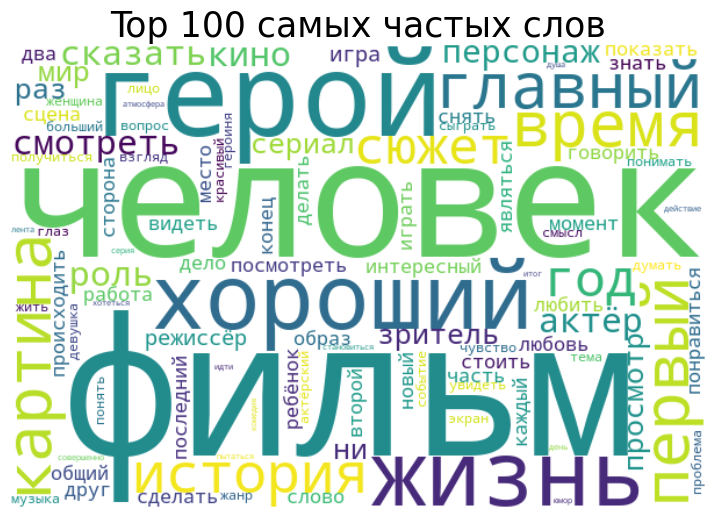

In [ ]:
fig = plt.figure(figsize=(10, 5), facecolor="white")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Top 100 самых частых слов", fontsize=25)
plt.tight_layout(pad=0)
plt.show()

Видим, что наиболее часто встречаемые слова являются общими ("фильм", "герой", "главный" и т.д.) - их нельзя отнести к положительным или отрицательным оценкам.  
Так же видим слово "хороший", частая встречаемость которого может быть вызвана преобладающей долей положительных отзывов.

## 5. Классификация отзывов

Выполним разбиение на тренировочную, валидационную и тестовую выборки.  
Учтем дисбаланс классов целевой переменной при помощи параметра `stratify`.

In [ ]:
X_train, X_val_test, y_train, y_val_test = train_test_split(
    df["cleaned_review"],
    df["sentiment"],
    test_size=0.4,
    stratify=df["sentiment"],
    random_state=RANDOM_STATE,
)

In [ ]:
X_val, X_test, y_val, y_test = train_test_split(
    X_val_test,
    y_val_test,
    test_size=0.5,
    stratify=y_val_test,
    random_state=RANDOM_STATE,
)

Выполним обучение и валидацию нескольких моделей без настройки гиперпараметров.  
Выведем отчеты с метриками, а также оценки по метрике f1-macro, так как мы хотим считать одинаково важными предсказания для всех классов, независимо от их размера.

In [ ]:
models = [
    ("Logistic Regression", LogisticRegression()),
    ("Random Forest", RandomForestClassifier(random_state=RANDOM_STATE)),
    ("Gradient Boosting", GradientBoostingClassifier(random_state=RANDOM_STATE)),
]

# Перебор моделей
for name, model in models:
    pipe = Pipeline(
        steps=[
            ("counter", CountVectorizer()),
            ("tfidf", TfidfTransformer()),
            ("clf", model),
        ]
    ).fit(X_train, y_train)

    preds = pipe.predict(X_val)
    print(f"Classification report for {name}:")
    print(classification_report(y_val, preds, zero_division=0))

    f1_macro = f1_score(y_val, preds, average="macro", zero_division=0)
    print(f"F1-score (macro) for {name}: {f1_macro:.4f}\n")

Classification report for Logistic Regression:
              precision    recall  f1-score   support

         neg       1.00      0.06      0.12        79
         neu       0.00      0.00      0.00        99
         pos       0.67      1.00      0.80       349

    accuracy                           0.67       527
   macro avg       0.56      0.35      0.31       527
weighted avg       0.59      0.67      0.55       527

F1-score (macro) for Logistic Regression: 0.3068

Classification report for Random Forest:
              precision    recall  f1-score   support

         neg       1.00      0.04      0.07        79
         neu       1.00      0.01      0.02        99
         pos       0.67      1.00      0.80       349

    accuracy                           0.67       527
   macro avg       0.89      0.35      0.30       527
weighted avg       0.78      0.67      0.54       527

F1-score (macro) for Random Forest: 0.2979

Classification report for Gradient Boosting:
           

На данном этапе видим, что лучше всех с данной задачей справляется градиентный бустинг.  
Соизмеримые метрики качества получаются для логистической регресии и случайного леса.

Далее выполним поиск оптимальных гиперпараметров для двух моделей - логистической регрессии и градиентного бустинга,  
также попробуем найти гиперпараметры для tf-idf векторизатора.  
Для поиска гиперпараметров будем использовать библиотеку Optuna.

In [ ]:
X_train_extended = pd.concat([X_train, X_val], axis=0)
y_train_extended = pd.concat([y_train, y_val], axis=0)

In [ ]:
def get_model(vectorizer_params={}, classifier_params={}, model_type="lg"):
    if model_type == "lg":
        classifier = LogisticRegression(**classifier_params)
    elif model_type == "rf":
        classifier = RandomForestClassifier(**classifier_params)
    elif model_type == "gb":
        classifier = GradientBoostingClassifier(**classifier_params)

    model = Pipeline(
        [
            ("vectorizer", TfidfVectorizer(**vectorizer_params)),
            ("clf", classifier),
        ]
    )

    return model

In [ ]:
def objective_lg(trial):
    ngram_range_str = trial.suggest_categorical("ngram_range", ["(1, 1)", "(1, 2)"])
    ngram_range = tuple(map(int, ngram_range_str.strip("()").split(",")))

    i_params = {
        "max_df": trial.suggest_float("max_df", 0.3, 0.7),
        "min_df": trial.suggest_float("min_df", 0.001, 0.005, log=True),
        "norm": trial.suggest_categorical("norm", ["l1", "l2"]),
        "ngram_range": ngram_range,
    }

    r_params = {"C": trial.suggest_float("C", 0.1, 1, log=True)}

    model = get_model(i_params, r_params, "lg")

    cv = StratifiedKFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True)

    score = cross_val_score(
        model,
        X_train_extended,
        y_train_extended,
        scoring="f1_macro",
        cv=cv,
        n_jobs=N_THREADS,
    )

    final_score = score.mean()

    return final_score

In [ ]:
study_lg = optuna.create_study(
    direction="maximize",
    study_name="study_lg",
    sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
    pruner=optuna.pruners.HyperbandPruner(),
)
study_lg.optimize(objective_lg, n_trials=20, n_jobs=N_THREADS)

In [ ]:
best_param_tf_idf_lg = study_lg.best_params

In [ ]:
best_param_tf_idf_lg

{'ngram_range': '(1, 1)',
 'max_df': 0.5085861681636625,
 'min_df': 0.004694742889582547,
 'norm': 'l2',
 'C': 0.9880215171664208}

In [ ]:
def objective_gb(trial):
    ngram_range_str = trial.suggest_categorical("ngram_range", ["(1, 1)", "(1, 2)"])
    ngram_range = tuple(map(int, ngram_range_str.strip("()").split(",")))

    i_params = {
        "max_df": trial.suggest_float("max_df", 0.3, 0.7),
        "min_df": trial.suggest_float("min_df", 0.001, 0.005, log=True),
        "norm": trial.suggest_categorical("norm", ["l1", "l2"]),
        "ngram_range": ngram_range,
    }

    r_params = {
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0, step=0.1),
        "max_features": trial.suggest_categorical(
            "max_features", [None, "log2", "sqrt"]
        ),
        "random_state": RANDOM_STATE,
    }

    model = get_model(i_params, r_params, "gb")

    cv = StratifiedKFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True)

    score = cross_val_score(
        model,
        X_train_extended,
        y_train_extended,
        scoring="f1_macro",
        cv=cv,
        n_jobs=N_THREADS,
    )

    final_score = score.mean()

    return final_score

In [ ]:
study_gb = optuna.create_study(
    direction="maximize",
    study_name="study_gb",
    sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
    pruner=optuna.pruners.HyperbandPruner(),
)
study_gb.optimize(objective_gb, n_trials=20, n_jobs=N_THREADS)

In [ ]:
study_gb.best_value

0.5066472486260614

In [ ]:
study_lg.best_value

0.3762071811731407

Видим, что поиск оптимальных гиперпараметров позволил увеличить метрику качества f1-macro для бустинга до 0.5.  
Далее в финальном pipeline применим именно его.

In [ ]:
best_param_tf_idf_gb = study_gb.best_params

In [ ]:
best_param_tf_idf_gb

{'ngram_range': '(1, 2)',
 'max_df': 0.30991184246417397,
 'min_df': 0.0011395995734958995,
 'norm': 'l2',
 'max_depth': 6,
 'learning_rate': 0.0922735819848502,
 'n_estimators': 292,
 'subsample': 0.4,
 'max_features': None}

In [ ]:
pipe = Pipeline(
    steps=[
        (
            "vectorizer",
            TfidfVectorizer(
                ngram_range=(1, 2),
                max_df=0.30991184246417397,
                min_df=0.0011395995734958995,
                norm="l2",
            ),
        ),
        (
            "clf",
            GradientBoostingClassifier(
                random_state=RANDOM_STATE,
                max_depth=6,
                learning_rate=0.0922735819848502,
                n_estimators=292,
                subsample=0.4,
                max_features=None,
            ),
        ),
    ]
).fit(X_train_extended, y_train_extended)

Выполним предсказания на тестовом наборе.

In [ ]:
predictions = pipe.predict(X_test)

In [ ]:
print("Classification report:")
print(classification_report(y_test, predictions, zero_division=0))

f1_macro = f1_score(y_test, predictions, average="macro", zero_division=0)
print(f"F1-score (macro): {f1_macro}")

Classification report:
              precision    recall  f1-score   support

         neg       0.67      0.30      0.41        80
         neu       0.39      0.19      0.26        99
         pos       0.75      0.95      0.84       348

    accuracy                           0.71       527
   macro avg       0.60      0.48      0.50       527
weighted avg       0.67      0.71      0.66       527

F1-score (macro): 0.501997632726572


По представленному отчету с метриками можно заметить, что хуже всего модели удается правильно улавливать нейтральные отзывы (*recall = 0.19*).  
Также модель плохо улавливает негативные отзывы (*recall = 0.30*).  
Лучше всего модель классифицирует позитивные отзывы (*recall = 0.95*), так как данный класс отзывов занимает внушительную долю среди всех отзывов.



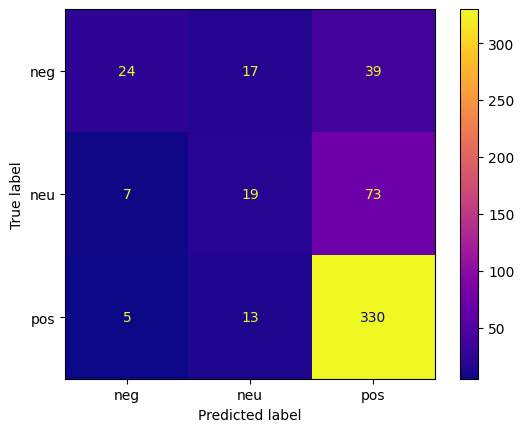

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, predictions, cmap="plasma")

Так же видим, что позитивные отзывы модель почти не пропускает.  
Из 99 нейтральных отзывов модель смогла верно классифицировать только 19. Она склонна ошибочно относить их позитивному классу.  
Из 80 негативных отзывов модель верно определила 24, при этом 39 из них она классифицировала как положительные, что является достаточно грубой ошибкой.

Посмотрим на несколько отзывов с ошибочными предсказаниями.

In [ ]:
X_test_original = df.loc[X_test.index]["review"]
X_test_original

745     Уже можно было расстраиваться, когда моё осозн...
1724    Дядя-мальчик и тетя-девочка. Две творческие ли...
768     'Мы любим. Мы настоящие. Мы люди. Им нас не уб...
2175    Как же долго я ждал этот фильм. Я надеялся на ...
989     Это мой любимый фильм с Джимом Керри. Этот фил...
                              ...                        
711     Наконец-то я добралась до просмотра Дона, при ...
260     Мне очень нравятся мультфильмы студии Диснея. ...
505      Совершенно непредсказуемый и стремительно раз...
708     Таков вопрос! Можно ли мне жить по-настоящему,...
2335    Мне сложно оценивать фильмы подобного рода из-...
Name: review, Length: 527, dtype: object

In [ ]:
test_results = pd.DataFrame(
    data={
        "Оригинальный отзыв": X_test_original,
        "Обработанный отзыв": X_test,
        "Истинная тональность": y_test,
        "Предсказанная тональность": predictions,
    }
)
test_results

,Оригинальный отзыв,Обработанный отзыв,Истинная тональность,Предсказанная тональность
745,"Уже можно было расстраиваться, когда моё осозн...",расстраиваться осознание бытие дойти пессимист...,pos,pos
1724,Дядя-мальчик и тетя-девочка. Две творческие ли...,дядя мальчик тётя девочка два творческий лично...,pos,pos
768,'Мы любим. Мы настоящие. Мы люди. Им нас не уб...,любить человек убить фильм мужской любовь ни к...,pos,pos
2175,Как же долго я ждал этот фильм. Я надеялся на ...,ждать фильм надеяться сильный место грустный э...,neu,pos
989,Это мой любимый фильм с Джимом Керри. Этот фил...,любимый фильм джим керри фильм заставлять друг...,pos,pos
...,...,...,...,...
711,"Наконец-то я добралась до просмотра Дона, при ...",добраться просмотр дон оба часть поговорить пе...,pos,pos
260,Мне очень нравятся мультфильмы студии Диснея. ...,нравиться мультфильм студия дисней дисней выпу...,pos,pos
505,Совершенно непредсказуемый и стремительно раз...,совершенно непредсказуемый стремительно развив...,pos,pos
708,"Таков вопрос! Можно ли мне жить по-настоящему,...",вопрос жить настоящему чувство бурный горячи п...,pos,pos


In [ ]:
test_results_sample = test_results.loc[
    test_results["Истинная тональность"] != test_results["Предсказанная тональность"]
].sample(5, random_state=RANDOM_STATE)

In [ ]:
def show_results(raw):
    print("---")
    print(f'Предсказали: {raw["Предсказанная тональность"]}')
    print("---")
    print(f'На самом деле: {raw["Истинная тональность"]}')
    print("---")
    print("Оригинальный отзыв")
    print(raw["Оригинальный отзыв"])
    print("---")
    print("Обработанный отзыв")
    print(raw["Обработанный отзыв"])
    print("---")
    print("\n" * 3)

In [ ]:
test_results_sample.apply(show_results, axis=1);

---
Предсказали: pos
---
На самом деле: neu
---
Оригинальный отзыв
Сначала было мной воспринято как чушь. Отец падает на стройке и разбивается насмерть. Мальчик от удара отлетает выше крыш домов и отделывается почему-то синяком под глазом. Реальная пара кроссовок с помойки и фантастическое существо, словно сошедшее со страниц комиксов Манго.

Однако, все это пронизано какой-то щемящей искренностью - как сцены сугубо реальной жизни, так и сцены с фантастическим существом. Думаю, что режиссер выражает собственную гуманную позицию, наделяя главных героев своего фильма добротой и состраданием.

Предлагаю два варианта режиссерского послания зрителю:
1) возможно, это эксперимент по соединению реальности и комиксов, по их взаимовлиянию и взаимопроникновению, каковой процесс можно наблюдать и в жизни;
2) возможно, целью режиссера являлся скрытый социальный протест, упакованный в фантастическую обертку.

Возможно, конечно, и третье... То есть присутствие в фильме и первого и ворого, а также нал

Если вчитаться в некоторые отзывы, то можно сделать вывод, что модель получилась так себе.  
Вероятно, неусшешность модели можно списать на используемую предварительную обработку и векторизатор.

Протестируем модель на других отзывах, найденных на кинопоиске.

In [ ]:
new_reviews = pd.read_excel("/kaggle/input/mydata/.xlsx")
new_reviews

,Фильм,Отзыв,Оценка
0,Переводчик (2022),Гай Ричи достиг пика своей карьеры благодаря с...,Негативная
1,Пчеловод (2024),"\nЭх, давно не попадалось такого яркого, по-хо...",Положительная
2,Еретик (2024),\n'Еретик' режиссеров Скотта Бека и Брайана Ву...,Нейтральная
3,Эбигейл (2024),\nШайка профессиональных мобстеров совершает д...,Нейтральная
4,Проклятие монахини 2 (2023),\nВот мы и дождались сиквела одного из спин-оф...,Негативная


In [ ]:
new_reviews["cleaned_review"] = new_reviews["Отзыв"].progress_apply(clean_text)
new_reviews["Оценка"] = new_reviews["Оценка"].map(
    {"Негативная": "neg", "Положительная": "pos", "Нейтральная": "neu"}
)

100%|██████████| 5/5 [00:00<00:00,  5.62it/s]


,Фильм,Отзыв,Оценка,cleaned_review
0,Переводчик (2022),Гай Ричи достиг пика своей карьеры благодаря с...,neg,гай ричи достигнуть пик карьера своевременный ...
1,Пчеловод (2024),"\nЭх, давно не попадалось такого яркого, по-хо...",pos,попадаться яркий хороший олдового боевик бить ...
2,Еретик (2024),\n'Еретик' режиссеров Скотта Бека и Брайана Ву...,neu,еретик режиссёр скотт бек брайан вудса предста...
3,Эбигейл (2024),\nШайка профессиональных мобстеров совершает д...,neu,шайка профессиональный мобстеров совершать дер...
4,Проклятие монахини 2 (2023),\nВот мы и дождались сиквела одного из спин-оф...,neg,дождаться сиквел спин оффов серия заклятие про...


In [ ]:
new_reviews_predictions = pipe.predict(new_reviews["cleaned_review"])

In [ ]:
new_reviews_results = pd.DataFrame(
    data={
        "Оригинальный отзыв": new_reviews["Отзыв"],
        "Обработанный отзыв": new_reviews["cleaned_review"],
        "Истинная тональность": new_reviews["Оценка"],
        "Предсказанная тональность": new_reviews_predictions,
    }
)
new_reviews_results

,Оригинальный отзыв,Обработанный отзыв,Истинная тональность,Предсказанная тональность
0,Гай Ричи достиг пика своей карьеры благодаря с...,гай ричи достигнуть пик карьера своевременный ...,neg,neg
1,"\nЭх, давно не попадалось такого яркого, по-хо...",попадаться яркий хороший олдового боевик бить ...,pos,neu
2,\n'Еретик' режиссеров Скотта Бека и Брайана Ву...,еретик режиссёр скотт бек брайан вудса предста...,neu,pos
3,\nШайка профессиональных мобстеров совершает д...,шайка профессиональный мобстеров совершать дер...,neu,pos
4,\nВот мы и дождались сиквела одного из спин-оф...,дождаться сиквел спин оффов серия заклятие про...,neg,neu


In [ ]:
new_reviews_results.apply(show_results, axis=1);

---
Предсказали: neg
---
На самом деле: neg
---
Оригинальный отзыв
Гай Ричи достиг пика своей карьеры благодаря своевременным хитам 'Гнев человеческий' и 'Джельтельмены', и теперь решил снимать в своё удовольствие по принципу - купят всё.

Эту идею справедливо поддержали прокатчики, и мы увидели сразу два неинтересных фильма, которые минимально скажутся на карьере режиссера.

'Переводчик', один из них. Зачем смотреть этот фильм?

Абсолютно не зачем, если только вам не интересно послушать оригинальную афганскую речь. Тем более весь сюжет известен из описания.

Судите сами: семейный чувак, имеющий шикарный дом в Калифорнии, зачем-то воюет в Афганистане. Его спасает Ахмед, и вернувшись в США, чувак пытается совершенно наивным способом выбить тому визу по телефону. А затем, бросает эту глупость, и налегке возвращается помочь самолично.

В этом фильме, телефон и звонки - вообще двигатель сюжета.

Гай Ричи же прославился в 00-е, работал в сюрреалистично-бандитском жанре, где позволялось множ

На новых отзывах модель отработала следующим образом:  
два нейтральных отзыва она классифицировала как положительные,  
положительный отзыв она отнесла к нейтральному,  
однако, что удивительно, один негативный отзыв она классифицировала верно,  
но при этом второй негативный отзыв она оценила как нейтральный.

Это еще раз подтверждает, что модель получилась плохого качества.